# Topic Modeling 

One of the primary applications of natural language processing is to automatically extract what topics people are discussing from large volumes of text. Some examples of large text could be feeds from social media, customer reviews of hotels, movies, user feedbacks, news stories, e-mails of customer complaints etc.

Knowing what people are talking about and understanding their problems and opinions is highly valuable to businesses, administrators, political campaigns. In our case, extracting the topics of product reviews can be useful to companies that sell products, who can use these results to improve their products, increase both sales and customer experiences.

Since it's really hard to manually read through such large volumes and compile the topics, it is important to find a way to do this in an automated way. In this notebook we therefore want to pursue this task to extract the main topics present in the negative reviews in our dataset. We focus on negative reviews because we believe that it is more interesting for companies selling products to understand why a negative review is negative than to know why a positive review is positive.

## Import Libraries

In [110]:
import pandas as pd
import numpy as np
import os
import sys
from pprint import pprint
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# spacy for lemmatization
import spacy

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## Load Dataset

We first proceed to load the dataset we will be working with and save it in the DataFrame `df`. 

In [6]:
#Get the directory of the script
script_directory = os.getcwd()
data_name="../Final_Dataset/Dataset_final.csv"
#Combine the script directory and folder name to get the full path
data_path = os.path.join(script_directory, data_name)

df=pd.read_csv(data_path)

We delete the `title` column, as we will only work with entire product reviews. We do this because the titles alone are not long enough to extract interesting topics. Entire reviews are longer and more detailed, and allow us to make a more meaningful distinction of topics. Then we only focus on data that have `polarity` equal to 1. In fact, as explained in the introduction, our study will only focus on negative reviews.

In [7]:
# Drop the 'title' column from the DataFrame
df = df.drop(columns="title")
# Filter the DataFrame to include only 'polarity' equal to 1 rows
df = df[df.polarity == 1]


In [8]:
df.head()

,polarity,text
0,1,"these looked really nice, but they had this we..."
1,1,i agree with buyers who say that the product i...
2,1,i bought this for my wife for christmas and sh...
3,1,this bra is definitely not what i was hoping f...
4,1,normally i would slap someone who said what i ...


In [9]:
df.isna().sum()

polarity    0
text        0
dtype: int64

## Text Prepocessing

In this section we pre-process the text data, so that it is ready for the application of the `LDA (Latent Dirichlet Allocation)` algorithm which we will use to identify the various topics.

### Text Cleaning

We begin by defining the `preprocess_senteces` function, which is responsible for this conversion: it strips out email addresses, spacing characters and single quotes, splits the text into words using Gensim's `simple_preprocess` function, and removes the punctuations.

In [10]:
def preprocess_senteces(sentences):
    '''
    Function to preprocess sentences by removing emails, newline characters, and single quotes,
    and then tokenize the sentences into words using Gensim's simple_preprocess.

    Parameters:
    - sentences: List of sentences to preprocess.

    Yields:
    - List of words for each sentence after preprocessing.
    '''
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)
        sent = re.sub('\s+', ' ', sent)
        sent = re.sub("\'", "", sent)
        
        # Tokenize the sentence into words
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) # deacc=True removes punctuations
        
        yield sent


At this point, we convert the text of the reviews into a list of words. This is important because LDA operates on a word-based representation of the text. We then pass each review through the `preprocess_sentences` function.

In [11]:
# Convert the 'text' column of the DataFrame to a list
data = df.text.values.tolist()
pprint(data[:1])


['these looked really nice, but they had this weird wood smell, so i returned '
 "them. i own a clear plastic olde thompson set, which i've had for years, but "
 'the pepper mill broke. the company sent me a new pepper mill since there is '
 'a lifetime warranty. great experience with olde thompson, just not with this '
 'particular product.']


In [12]:
# Convert the text data into words using the sent_to_words function
data_words = list(preprocess_senteces(data))
pprint(data_words[:1])


[['these',
  'looked',
  'really',
  'nice',
  'but',
  'they',
  'had',
  'this',
  'weird',
  'wood',
  'smell',
  'so',
  'returned',
  'them',
  'own',
  'clear',
  'plastic',
  'olde',
  'thompson',
  'set',
  'which',
  'ive',
  'had',
  'for',
  'years',
  'but',
  'the',
  'pepper',
  'mill',
  'broke',
  'the',
  'company',
  'sent',
  'me',
  'new',
  'pepper',
  'mill',
  'since',
  'there',
  'is',
  'lifetime',
  'warranty',
  'great',
  'experience',
  'with',
  'olde',
  'thompson',
  'just',
  'not',
  'with',
  'this',
  'particular',
  'product']]


### Create Bigram and Trigram Models

We now construct models of bigrams and trigrams for our text corpus. These models identify common phrases of two and three words respectively. We use `Phraser` objects to efficiently apply the models to our documents. The two important arguments to Phrases are `min_count` and `threshold`. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Create a Phraser object for the bigram and trigram models 
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [14]:
pprint(trigram_mod[bigram_mod[data_words[0]]])

['these',
 'looked',
 'really',
 'nice',
 'but',
 'they',
 'had',
 'this',
 'weird',
 'wood',
 'smell',
 'so',
 'returned',
 'them',
 'own',
 'clear',
 'plastic',
 'olde',
 'thompson',
 'set',
 'which',
 'ive',
 'had',
 'for',
 'years',
 'but',
 'the',
 'pepper_mill',
 'broke',
 'the',
 'company',
 'sent',
 'me',
 'new',
 'pepper_mill',
 'since',
 'there',
 'is',
 'lifetime_warranty',
 'great',
 'experience',
 'with',
 'olde',
 'thompson',
 'just',
 'not',
 'with',
 'this',
 'particular',
 'product']


### Stopwords, Bigrams and Lemmatization

Finally, we define several functions to process our text data before applying topic modelling algorithms. The `remove_stopwords` function removes the stop words from each document in the text list, returning a list of documents without the stop words. The `make_bigrams` function generates bigrams for each document in the text list using the previously created bigram template. Similarly, the `make_trigrams` function generates trigrams for each document using both the biggrams model and the trigrams model.

We then define the `lemmatization` function, which lemmatises documents by retaining only the specified part-of-speech tags (in this case nouns, adjectives, verbs and adverbs). This function uses the `spaCy` model to process each sentence and returns a list of lemmatised documents.

These operations allow us to prepare our text data efficiently for subsequent analysis, such as the application of the `Latent Dirichlet Allocation (LDA)` algorithm for topic modelling.

In [15]:
def remove_stopwords(texts):
    '''
    Remove stopwords from each document in the list of texts.
    Parameters:
        texts: List of documents where each document is a list of words
    Returns:
        List of documents with stopwords removed
    '''
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [16]:
def make_bigrams(texts):
    '''
    Generate bigrams for each document in the list of texts using the bigram model.
    Parameters:
        texts: List of documents where each document is a list of words
    Returns:
        List of documents with bigrams generated
    '''
    return [bigram_mod[doc] for doc in texts]

In [17]:
def make_trigrams(texts):
    '''
    Generate trigrams for each document in the list of texts using both the bigram and trigram models.
    Parameters:
        texts: List of documents where each document is a list of words
    Returns:
        List of documents with trigrams generated
    '''
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [18]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    '''
    Lemmatize the documents, keeping only the specified part-of-speech tags.
    Parameters:
        texts: List of documents where each document is a list of words
        allowed_postags: List of part-of-speech tags to keep after lemmatization
    Returns:
        texts_out: List of lemmatized documents
    '''
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))  # Process the sentence with spaCy
        # Append the lemmatized tokens to the output list if their POS tag is in allowed_postags
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [19]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [20]:
pprint(data_lemmatized[:1])

[['look',
  'really',
  'nice',
  'weird',
  'wood',
  'smell',
  'return',
  'clear',
  'plastic',
  'thompson',
  'set',
  've',
  'year',
  'pepper_mill',
  'broke',
  'company',
  'send',
  'new',
  'pepper_mill',
  'lifetime_warranty',
  'great',
  'experience',
  'particular',
  'product']]


## Build Topic Model

In this section we define our Topic Modeling model, and we see the first results.

Firstly, we create a dictionary and a corpus that will serve as the main input for the LDA topic modelling.
- We use Gensim's `corpora.Dictionary` function to create a dictionary, `id2word`, from our lemmatised data. This dictionary contains a mapping between each unique word and a unique identifier (ID). In other words, the dictionary associates each word in our dataset with a unique ID.
- We assign our lemmatised data to the variable `texts`. The corpus is a representation of our texts in a format that can be used by the LDA model.
- We create the `corpus` using a list comprehension that calls the `doc2bow` method of the id2word dictionary for each text in texts. doc2bow transforms each document into a list of tuples, where each tuple contains a word ID and its number of occurrences in the corresponding document. This represents the frequency of terms in the documents.

In [21]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [22]:
pprint(corpus[:1])

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 2),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1)]]


If we want to see which word a given id corresponds to, we can pass the id as a dictionary key. Or we can see a human-readable form of the corpus itself.

In [23]:
id2word[0]

'broke'

In [24]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('broke', 1),
  ('clear', 1),
  ('company', 1),
  ('experience', 1),
  ('great', 1),
  ('lifetime_warranty', 1),
  ('look', 1),
  ('new', 1),
  ('nice', 1),
  ('particular', 1),
  ('pepper_mill', 2),
  ('plastic', 1),
  ('product', 1),
  ('really', 1),
  ('return', 1),
  ('send', 1),
  ('set', 1),
  ('smell', 1),
  ('thompson', 1),
  ('ve', 1),
  ('weird', 1),
  ('wood', 1),
  ('year', 1)]]

Finally, we use Gensim's `LdaModel` function to create our LDA model, passing several key parameters:
- `corpus=corpus`: We provide the corpus containing the bag-of-words (BoW) representation of our documents.
- `id2word=id2word`: We provide the dictionary that maps each unique word to a unique ID.
- `num_topics=8`: We specifie the number of topics that the model should find in the data. In this case, we decided to identify 8 topics.
- `random_state=100`: We set a random seed to ensure the reproducibility of the results.
- `update_every=1`: We set the model to update after each pass through the corpus.
- `chunksize=100`: We define the size of the data blocks processed in a single pass.
- `passes=10`: We specifie the number of passes the model must make over the entire corpus during training.
- `alpha='auto`: We allow the model to automatically adjust the alpha hyperparameter, which controls the distribution of topics per document.
- `per_word_topics=True`: We set the model to provide the probability of each word for each topic.

In [35]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


After much testing, we decided to extract 8 topics from our negative reviews. In the results printed above, we see the top 10 keywords contributing to each topic and their weight. Using these keywords, we tried to identify the main topic of each topic. 

![Topics](../Figures/topic_modeling.png)

More in detail:

0. `General Product Experience`: This topic reflects general experiences with products, where users discuss how they obtained the product, the time it took, and their overall judgment. Words like "get", "make", "well", and "time" indicate comments on the purchase and use of the product.

1. `Books`: This topic is clearly focused on book reviews. Users talk about reading books, the plot, writing, characters, and their emotions regarding the story.

2. `Movies and Music`: This topic deals with reviews of movies and music. Users express their opinions on movies and songs, commenting on the quality of the film and music, and their viewing and listening experiences.

3. `Ideas and Offers`: This topic seems to be about product ideas and offers. Users discuss what they wish for in products, the service they received, and their observations and opinions.

4. `Product Quality and Features`: This topic concerns the quality and features of products. Users talk about their experience with the products, camera quality, product features, and the match with the provided description.

5. `Product Issues`: This topic focuses on specific issues encountered with products, such as lights, falling, job quality, hair, smells, and appearance. Users express their frustrations and dissatisfaction with these issues.

6. `Product Purchase and Functionality`: This topic is about the purchase and functionality of products. Users discuss issues with the product's operation, usage, and unmet expectations regarding their purchases.

7. `Replacements and Customer Service`: This topic focuses on problems with replacements and customer service. Users talk about defective units, the need for replacements, waiting times, and their overall experiences with customer service.

### Model Perplexity and Coherence Score

We now calculate the `Perplexity` and `Coherence Score` of the model defined above. Perplexity is a metric that measures how effective the model is at predicting a test sample, with lower values indicating better performance. In contrast, the Coherence Score is a metric that assesses the consistency of the topics generated by the model, with higher scores indicating greater consistency between topics.

In [38]:
# Compute Perplexity
print('Perplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)


Perplexity:  -8.220545519231257
Coherence Score:  0.432423448247795


We can now use the metrics above to work out which is the best number of topics to identify in our text. To do this, we create a model that identifies a number of topics ranging from 4 to 8 topics, calculate `Coherence Score` and `Perplexity`, and see which model performs best.

In [44]:
# Initialize lists to store coherence scores and perplexities
coherence_scores = []
perplexities = []
num_topics_range = range(3, 11)

for num_topics in num_topics_range:
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_topics, 
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
    
    # Compute Perplexity
    perplexity = lda_model.log_perplexity(corpus)
    perplexities.append(perplexity)

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)

    print(f'num_topics = {num_topics}, Perplexity = {perplexity}, Coherence Score = {coherence_lda}')

num_topics = 3, Perplexity = -7.864111793555117, Coherence Score = 0.4748321681078685
num_topics = 4, Perplexity = -7.935639495693947, Coherence Score = 0.48663565175340207
num_topics = 5, Perplexity = -7.985859037801747, Coherence Score = 0.4592557683780246
num_topics = 6, Perplexity = -8.057814523732409, Coherence Score = 0.42843348984767643
num_topics = 7, Perplexity = -8.119084076571166, Coherence Score = 0.44135146464121094
num_topics = 8, Perplexity = -8.220545518598447, Coherence Score = 0.432423448247795
num_topics = 9, Perplexity = -8.362669926532467, Coherence Score = 0.42134728111067765
num_topics = 10, Perplexity = -8.609978373472051, Coherence Score = 0.4359016859025761


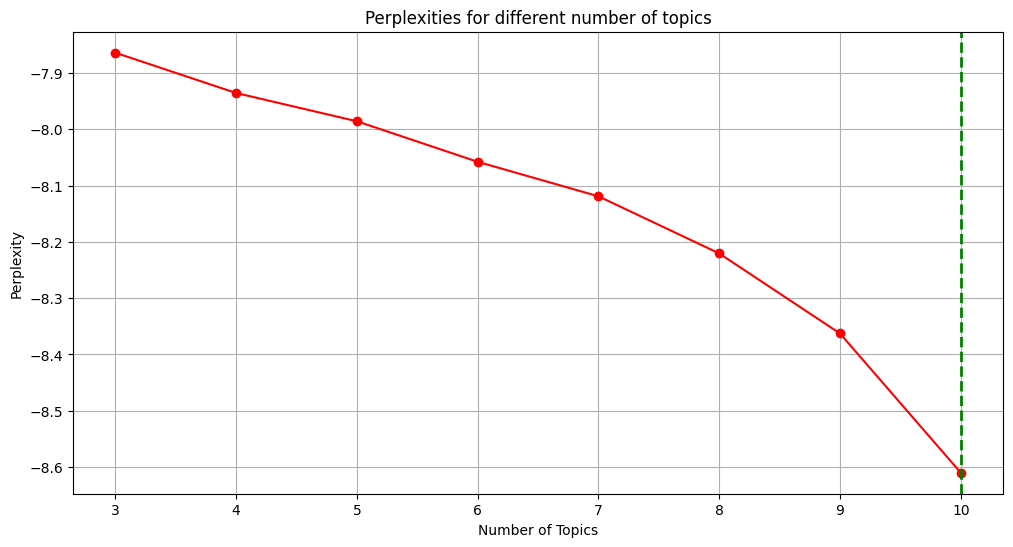

In [46]:
# Plot Perplexities
plt.figure(figsize=(12, 6))
plt.plot(num_topics_range, perplexities, marker='o', linestyle='-', color='r')
plt.title('Perplexities for different number of topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.xticks(num_topics_range)
plt.grid()

# Add vertical line at num_topic = 8
plt.axvline(x=10, color='g', linestyle='--', linewidth=2)

plt.show()

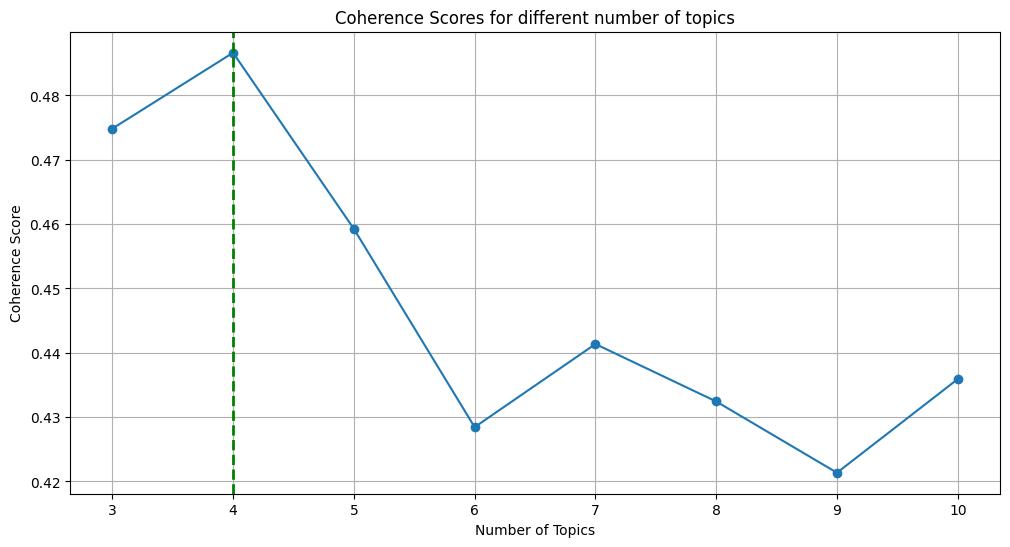

In [47]:
# Plot Coherence Scores
plt.figure(figsize=(12, 6))
plt.plot(num_topics_range, coherence_scores, marker='o', linestyle='-')
plt.title('Coherence Scores for different number of topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(num_topics_range)
plt.grid()

# Add vertical line at num_topic = 8
plt.axvline(x=4, color='g', linestyle='--', linewidth=2)

plt.show()

As we can see from the two graphs, the best result for Perplexity does not correspond to the best result for Coherence Score. However, these two metrics serve different purposes. The Coherence Score is more important when it comes to interpreting the data and understanding the topics. This metric is preferred for qualitative analysis. On the other hand, Perplexity is more important when the goal is to build a model that generalizes well to new data.

For our task we want to carry out a qualitative analysis, so we want to maximise the Coherence Score. So we decide to set `num_topics=4`, being the number that maximises the Coherence Score.

In [72]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [77]:
pprint(lda_model.print_topics(num_words=20))

[(0,
  '0.024*"work" + 0.018*"product" + 0.015*"buy" + 0.014*"use" + '
  '0.012*"purchase" + 0.009*"return" + 0.009*"problem" + 0.008*"order" + '
  '0.007*"get" + 0.007*"month" + 0.007*"item" + 0.006*"back" + 0.006*"receive" '
  '+ 0.006*"try" + 0.006*"day" + 0.006*"year" + 0.005*"price" + 0.005*"week" + '
  '0.005*"send" + 0.005*"small"'),
 (1,
  '0.061*"book" + 0.022*"read" + 0.021*"movie" + 0.012*"story" + 0.011*"write" '
  '+ 0.009*"character" + 0.009*"find" + 0.009*"author" + 0.008*"film" + '
  '0.007*"page" + 0.006*"end" + 0.006*"many" + 0.005*"people" + 0.005*"life" + '
  '0.005*"plot" + 0.005*"seem" + 0.004*"interesting" + 0.004*"much" + '
  '0.004*"series" + 0.004*"man"'),
 (2,
  '0.023*"get" + 0.017*"good" + 0.016*"time" + 0.015*"well" + 0.015*"make" + '
  '0.014*"go" + 0.013*"even" + 0.012*"buy" + 0.011*"bad" + 0.010*"think" + '
  '0.010*"money" + 0.010*"really" + 0.010*"first" + 0.009*"look" + 0.009*"say" '
  '+ 0.009*"thing" + 0.009*"great" + 0.009*"much" + 0.008*"see" + '

## Results Analysis

In this section, we analyze the results obtained after dividing our dataset into 4 different classes. We carry out various types of analysis and always provide a visual representation of the results obtained.

### Dominant Topic for each Review

In LDA models, each document consists of multiple topics. However, typically only one of the topics is dominant. In this section, we write code to understand the dominant topic for each review.

We initially define the function `format_topics_sentences`, which takes an LDA model, a text corpus, and a list of texts as input. This function allows us to obtain a DataFrame containing the main information for each document in our corpus, including the dominant topic, the percentage contribution of the dominant topic, the keywords of the topic, and the original text of the document. We then pass our model through this function, obtaining a new DataFrame called `df_dominant_topic`, in order to study its results. 

In [78]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    '''
    This function formats the topics for each document in the corpus using the provided LDA model. It identifies the dominant topic in each document, along with its percentage contribution and the keywords associated with that topic. The resulting information is compiled into a DataFrame.

    Parameters:
    - ldamodel: The trained LDA model.
    - corpus: The corpus on which the LDA model was trained.
    - texts: The original texts of the documents.

    Returns:
    - A DataFrame where each row corresponds to a document, including the dominant topic, its percentage contribution, the keywords for that topic, and the original text.
    '''
    # Initialize the output DataFrame
    sent_topics_df = pd.DataFrame()

    # Get the main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # Sort the topics for each document by their contribution in descending order
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the dominant topic, percentage contribution, and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                # Create a temporary DataFrame and concatenate
                temp_df = pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]], 
                                       columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])
                sent_topics_df = pd.concat([sent_topics_df, temp_df], ignore_index=True)
            else:
                break

    # Add the original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [79]:
# Format the topics for each document in the corpus
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

# Format the resulting DataFrame
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,0.5658,"work, product, buy, use, purchase, return, problem, order, get, month","[look, really, nice, weird, wood, smell, return, clear, plastic, thompson, set, ve, year, pepper..."
1,1,2,0.6868,"get, good, time, well, make, go, even, buy, bad, think","[agree, buyer, say, product, good, trying, replace, neck, pillow, buy, last, year, old, new, one..."
2,2,0,0.5878,"work, product, buy, use, purchase, return, problem, order, get, month","[buy, disappointed, smell, smell, beautiful, oder, seem, strong, bottle, buy, kind, like, water,..."
3,3,2,0.7108,"get, good, time, well, make, go, even, buy, bad, think","[bra, definitely, hope, supportive, thin, material, flattering, make, look, pointy, definitely, ..."
4,4,1,0.3891,"book, read, movie, story, write, character, find, author, film, page","[normally, slap, say, title, film, deserve, restore, view, way, mean, see, save, film, terrible,..."
5,5,1,0.7136,"book, read, movie, story, write, character, find, author, film, page","[disappoint, book, hail, proust, find, depth, author, novel, confuse, difficult, read, maybe, un..."
6,6,2,0.5360,"get, good, time, well, make, go, even, buy, bad, think","[reason, hillman, stand, band, even, singing, group, byrd, know, know, intend, cater, know, make..."
7,7,0,0.4389,"work, product, buy, use, purchase, return, problem, order, get, month","[welllook, sucker, writen, face, todead, door, nail, suck, battery, start, give, good, long, cha..."
8,8,0,0.5447,"work, product, buy, use, purchase, return, problem, order, get, month","[fit, office, patrician, fit, say, office, floor, look, sturdy, measure, wall, purchase, definit..."
9,9,0,0.5003,"work, product, buy, use, purchase, return, problem, order, get, month","[buy, use, law, work, great, want, home, want, tall, gate, bring, summer, play, yard, good, ligh..."


### Most Representive Sentece for each Topic

In this section we instead create a DataFrame, called `sentence_topics`, which contains the most representative reviews for each topic. We then print out the results.

In [80]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

# Initialize DataFrame to store sorted topics
sentence_topics = pd.DataFrame()

# Group by dominant topic
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

# Iterate over each group to find the most representative text for each topic
for i, grp in sent_topics_outdf_grpd:
    # Sort documents by percentage contribution to the topic in descending order and select the top document
    sentence_topics = pd.concat([sentence_topics, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset the index
sentence_topics.reset_index(drop=True, inplace=True)

# Rename columns
sentence_topics.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

In [81]:
# Display the DataFrame
sentence_topics.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.8970,"work, product, buy, use, purchase, return, problem, order, get, month","[buy, panasonic, phone, headset, amazon, headset, work, phone, get, satisfaction, call, get, reg..."
1,1,0.8563,"book, read, movie, story, write, character, find, author, film, page","[rarely, write, review, book, felt_compelle, write, review, book, disappointing, read, book, jod..."
2,2,0.9299,"get, good, time, well, make, go, even, buy, bad, think","[buy, think, remix, song, singing, finally, buy, listen, different, people, singe, song, dissapo..."
3,3,0.8366,"game, band, play, fall, suck, matter, text, program, concept, notice","[contiene, grabacione, originale, sino, nuevas, grabacione, originale, perdido, juventud, fuerza..."


### Frequency Distribution of Word Counts 

In this section, we aim to understand the overall size of the documents and their distribution across different topics. First, we start by visualizing the `Distribution of Document Word Counts` for the entire dataset. Then, we create four individual plots arranged in a 2x2 grid, each representing the distribution of document lengths for a specific topic. Each plot is color-coded according to the corresponding topic. As observed, topics 0 and 2 not only represent the most numerous topics but also exhibit distributions that closely resemble the overall dataset.

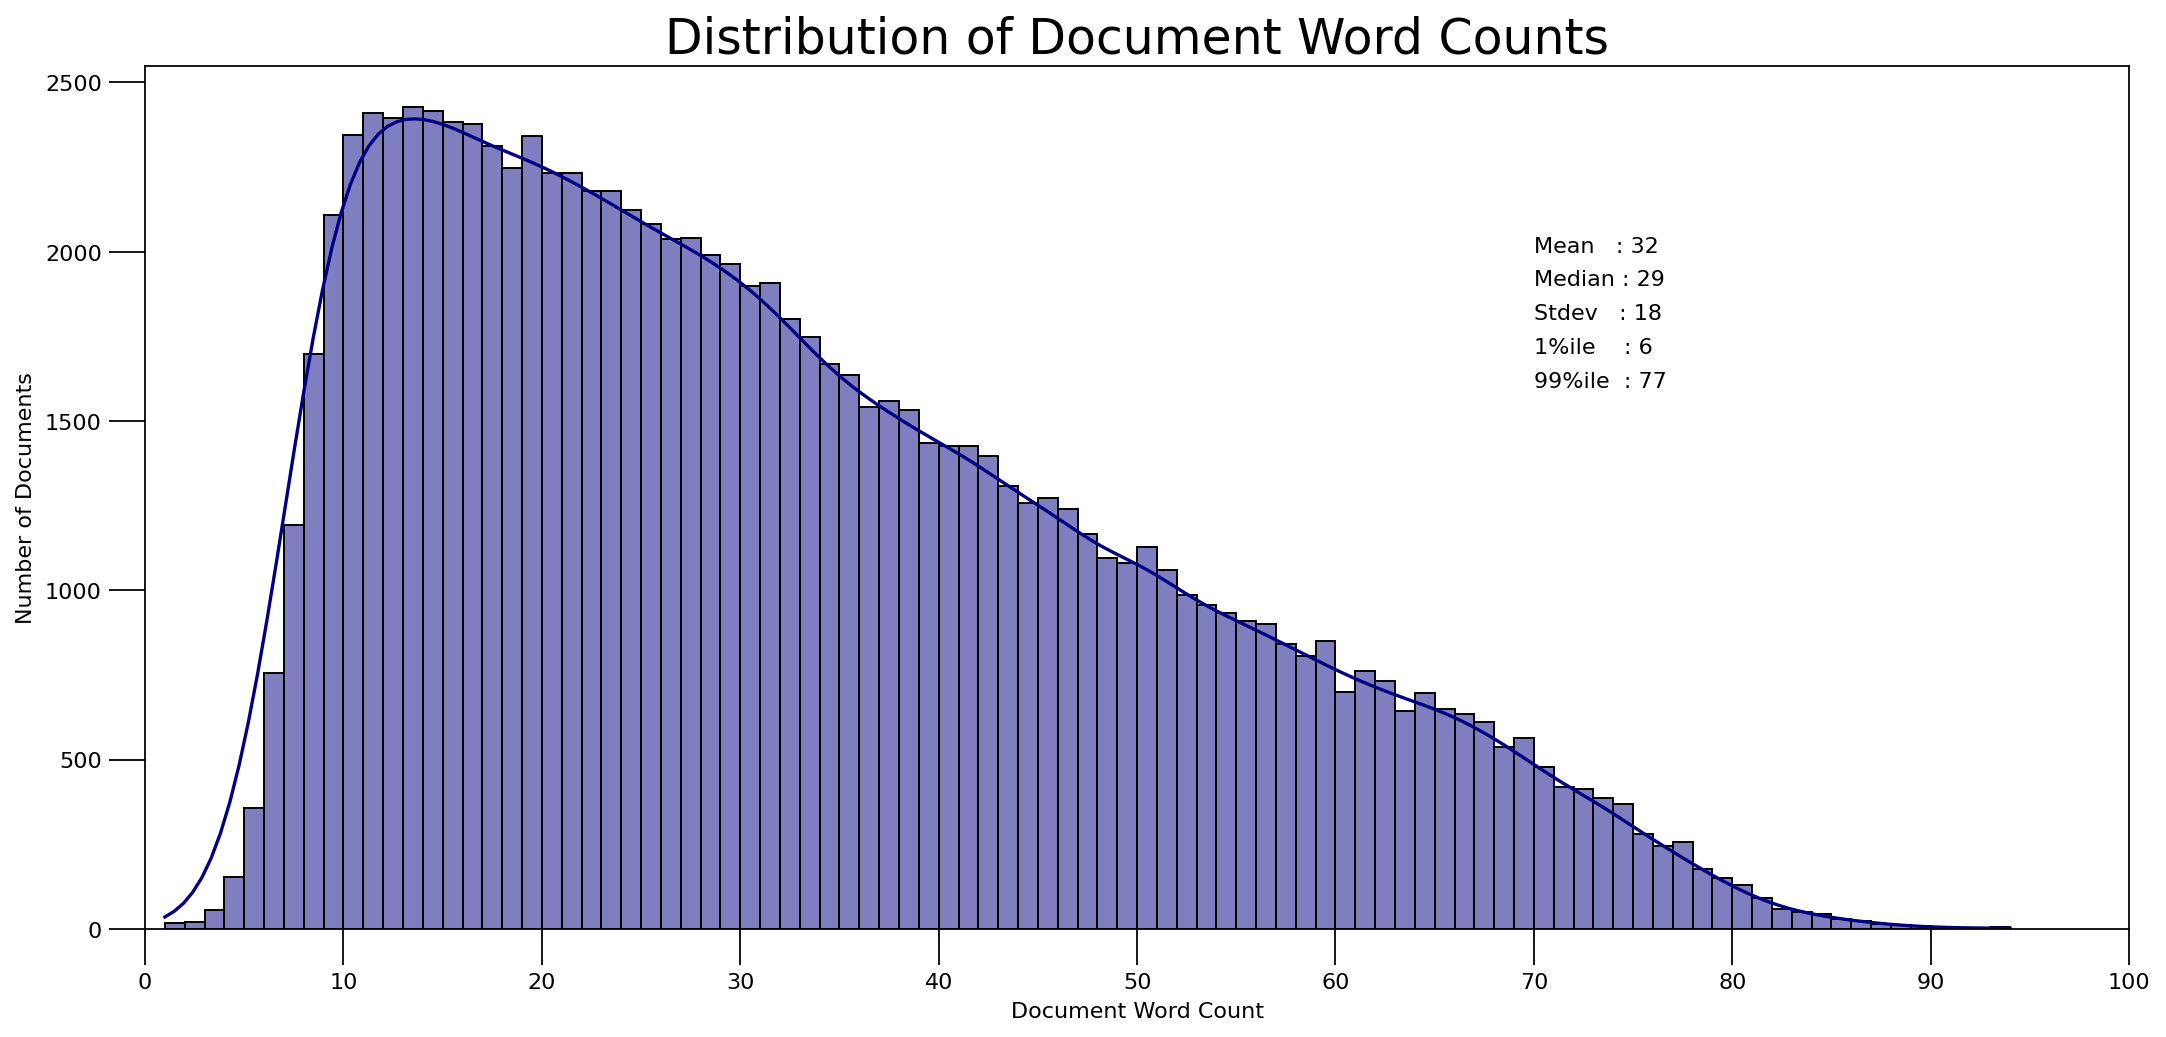

In [82]:
# Calculate the length of each document in terms of word count
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plotting using sns.histplot
plt.figure(figsize=(16,7), dpi=160)
sns.histplot(doc_lens, bins=1000, color='navy', binwidth=1, kde=True)

# Adding statistical information as text annotations on the plot
plt.text(70, 2000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(70, 1900, "Median : " + str(round(np.median(doc_lens))))
plt.text(70, 1800, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(70, 1700, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(70, 1600, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

# Setting plot properties
plt.gca().set(xlim=(0, 100), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0, 100, 11))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()


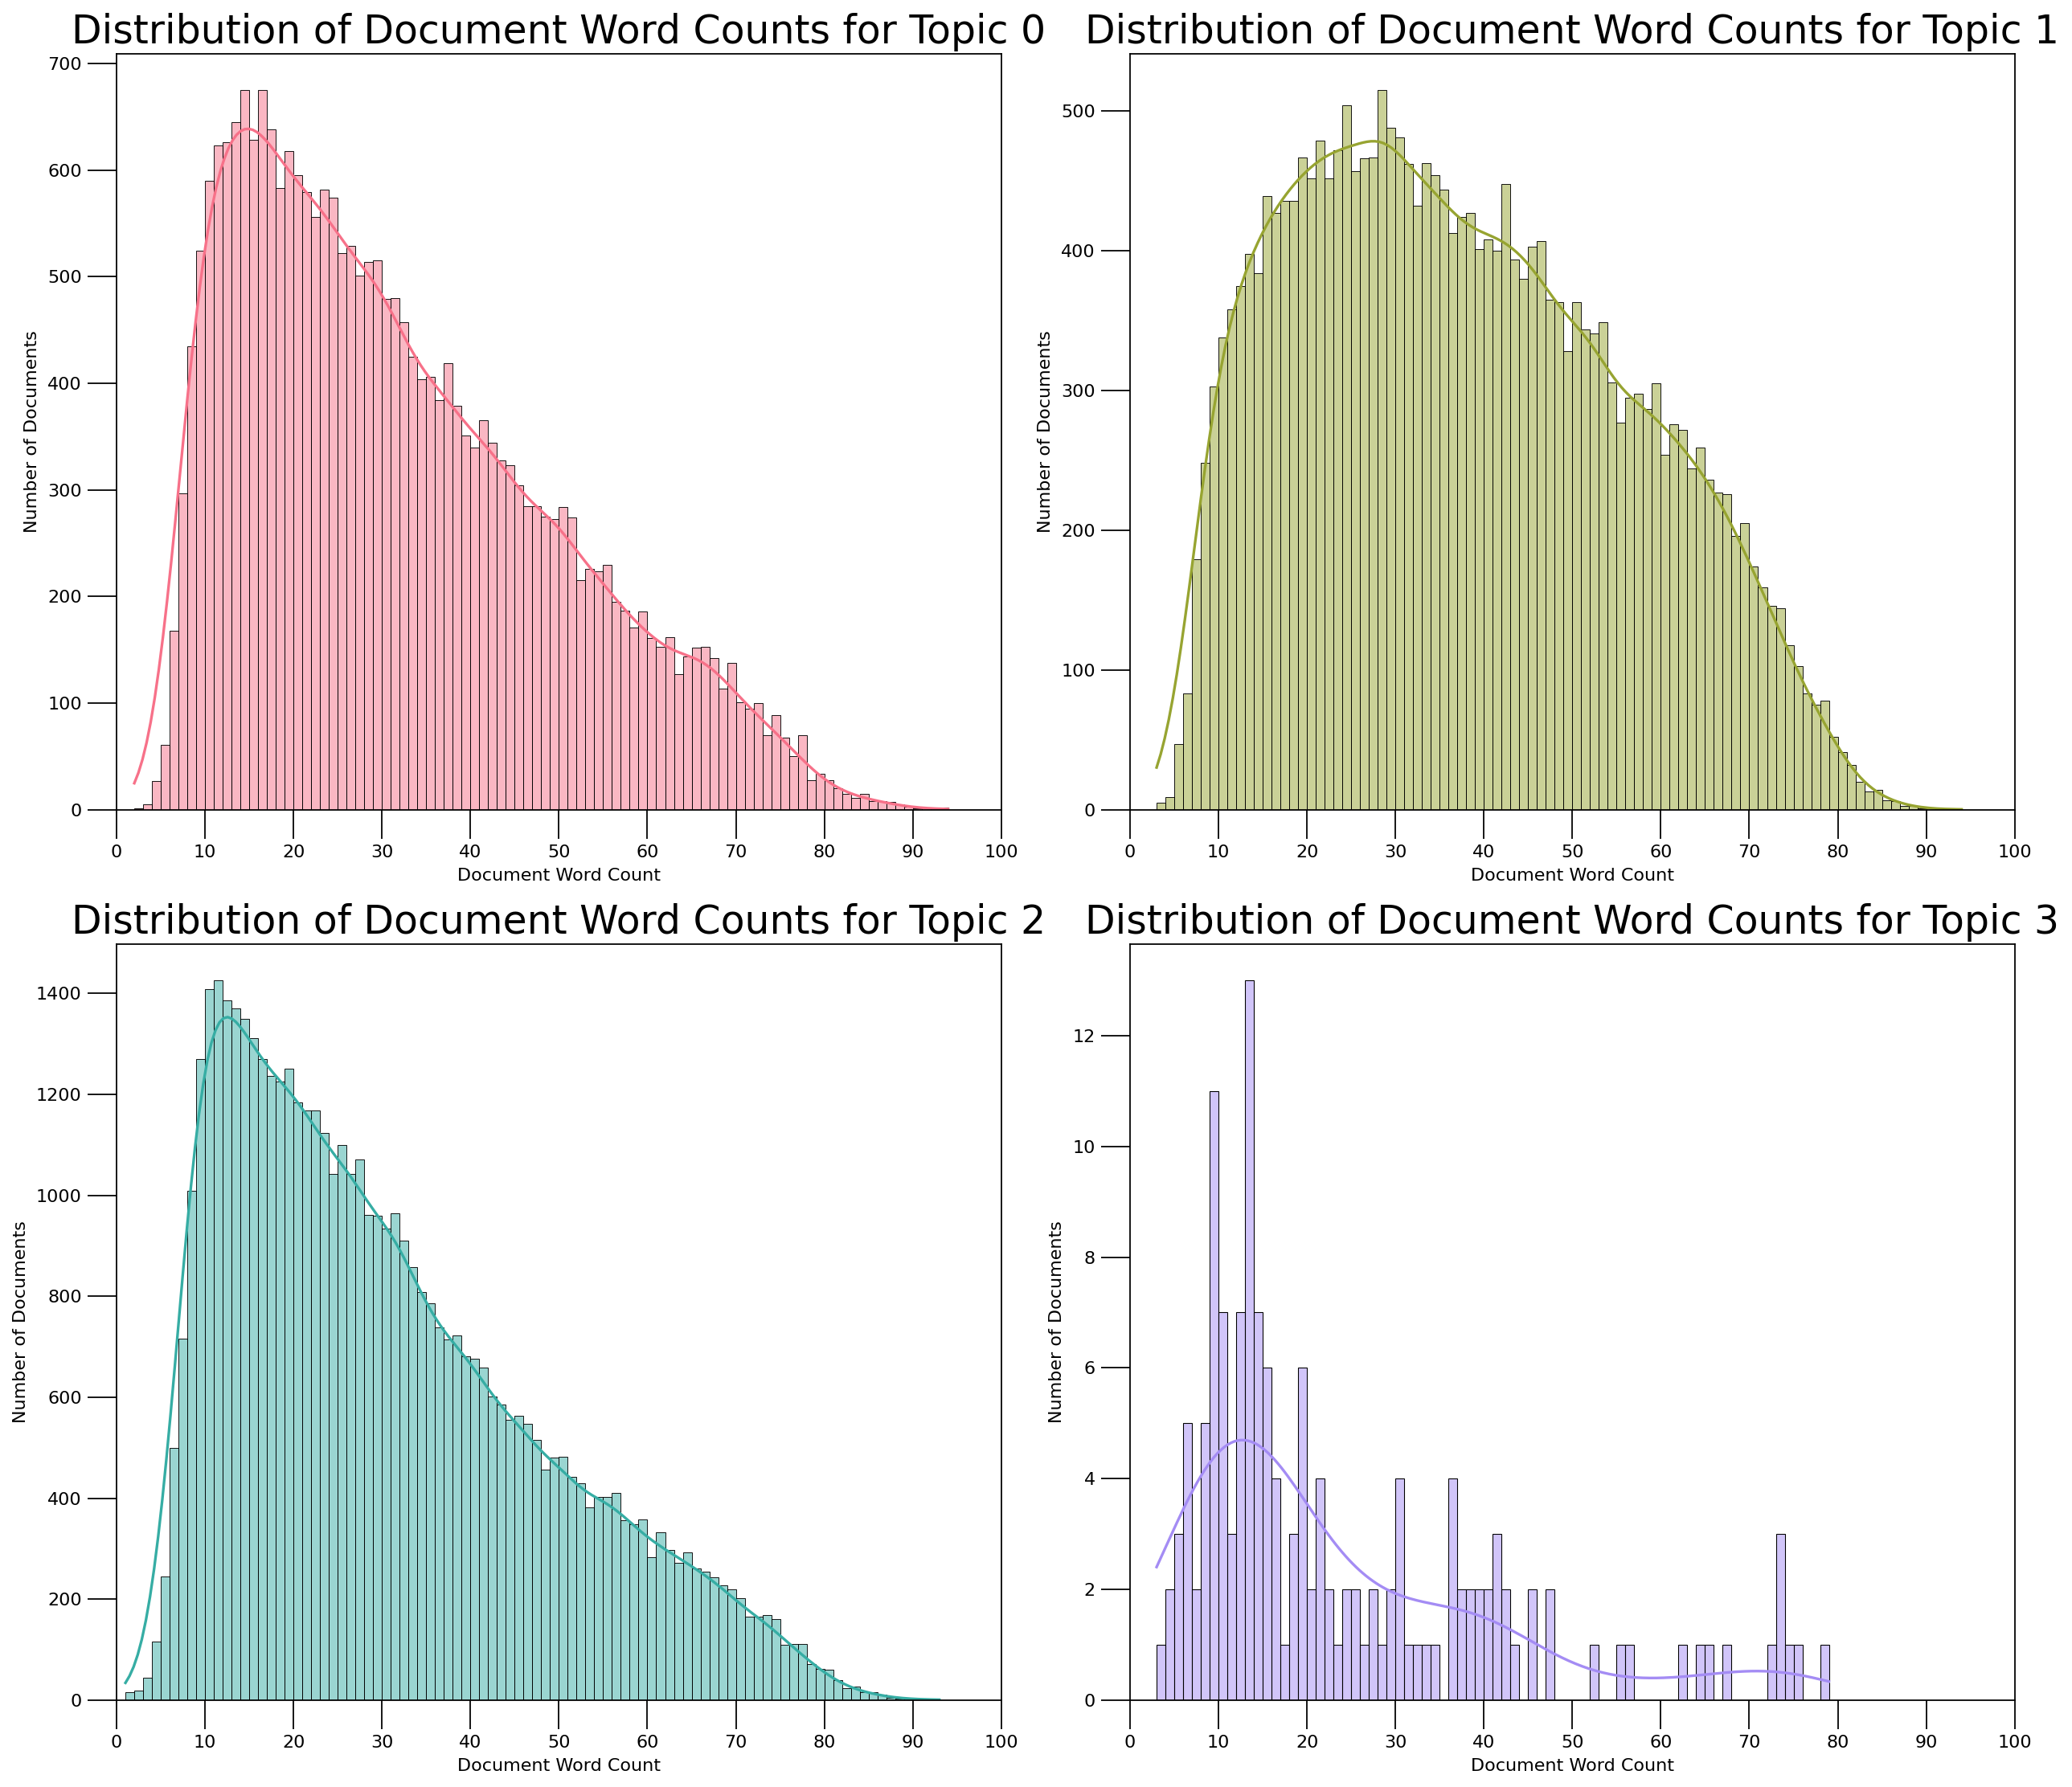

In [91]:
# Define color palette
palette = sns.color_palette("husl", 4)

# Calculate the length of each document in terms of word count for each topic
doc_lens_per_topic = {}
for topic_num in range(4):
    doc_lens_per_topic[topic_num] = [len(d) for d in df_dominant_topic[df_dominant_topic['Dominant_Topic'] == topic_num].Text]

# Plotting for each topic
fig, axes = plt.subplots(2, 2, figsize=(16, 14), dpi=160)
for topic_num, doc_lens_topic in doc_lens_per_topic.items():
    sns.histplot(doc_lens_topic, bins=1000, color=palette[topic_num], binwidth=1, kde=True, ax=axes.flatten()[topic_num])

    # Setting plot properties
    axes.flatten()[topic_num].set(xlim=(0, 100), ylabel='Number of Documents', xlabel='Document Word Count')
    axes.flatten()[topic_num].tick_params(size=16)
    axes.flatten()[topic_num].set_xticks(np.linspace(0, 100, 11))
    axes.flatten()[topic_num].set_title(f'Distribution of Document Word Counts for Topic {topic_num}', fontdict=dict(size=22))

plt.tight_layout()
plt.show()

### WordCloud

In this section, we print the top 10 keywords for each topic using `WordCloud`. Although we have already seen what the main words for each topic are, this representation is more visually immediate.

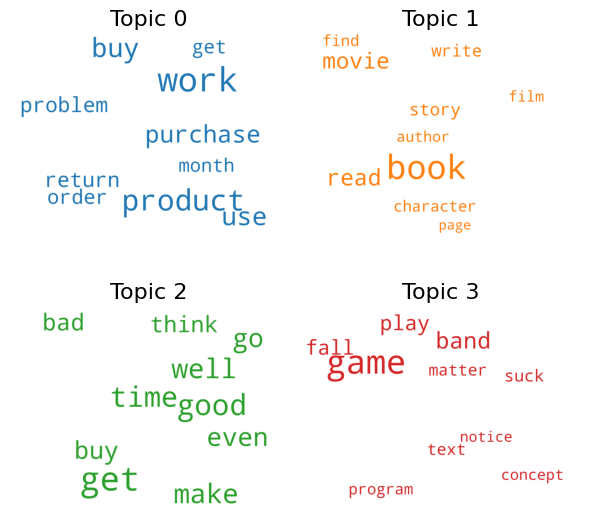

In [103]:
# Extracting colors from the TABLEAU_COLORS palette for coloring word clouds
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # Additional colors can be obtained from 'mcolors.XKCD_COLORS'

# Configuring WordCloud parameters
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',  # Color map for the word cloud
                  color_func=lambda *args, **kwargs: cols[i],  # Coloring each word cloud based on topic
                  prefer_horizontal=1.0)

# Obtaining topics from the LDA model
topics = lda_model.show_topics(formatted=False)

# Creating a 2x2 grid for displaying word clouds for each topic
fig, axes = plt.subplots(2, 2, figsize=(6,6), sharex=True, sharey=True)

# Iterating through each subplot to generate word clouds for each topic
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])  # Extracting words and their probabilities for the current topic
    cloud.generate_from_frequencies(topic_words, max_font_size=300)  # Generating word cloud based on word frequencies
    plt.gca().imshow(cloud)  # Displaying the word cloud on the current axis
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))  # Setting the title for the current topic
    plt.gca().axis('off')  # Turning off axis for the current plot

# Adjusting subplot layout
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')  # Turning off axis for the entire plot
plt.margins(x=0, y=0)
plt.tight_layout()  # Ensuring tight layout
plt.show()  # Displaying the plot

### Word Counts of Topic Keywords

Instead, we now graphically print the importance of each of the keywords in each topic. Again, we had already printed these values when we created the template, but this way the printed results will be more immediate.

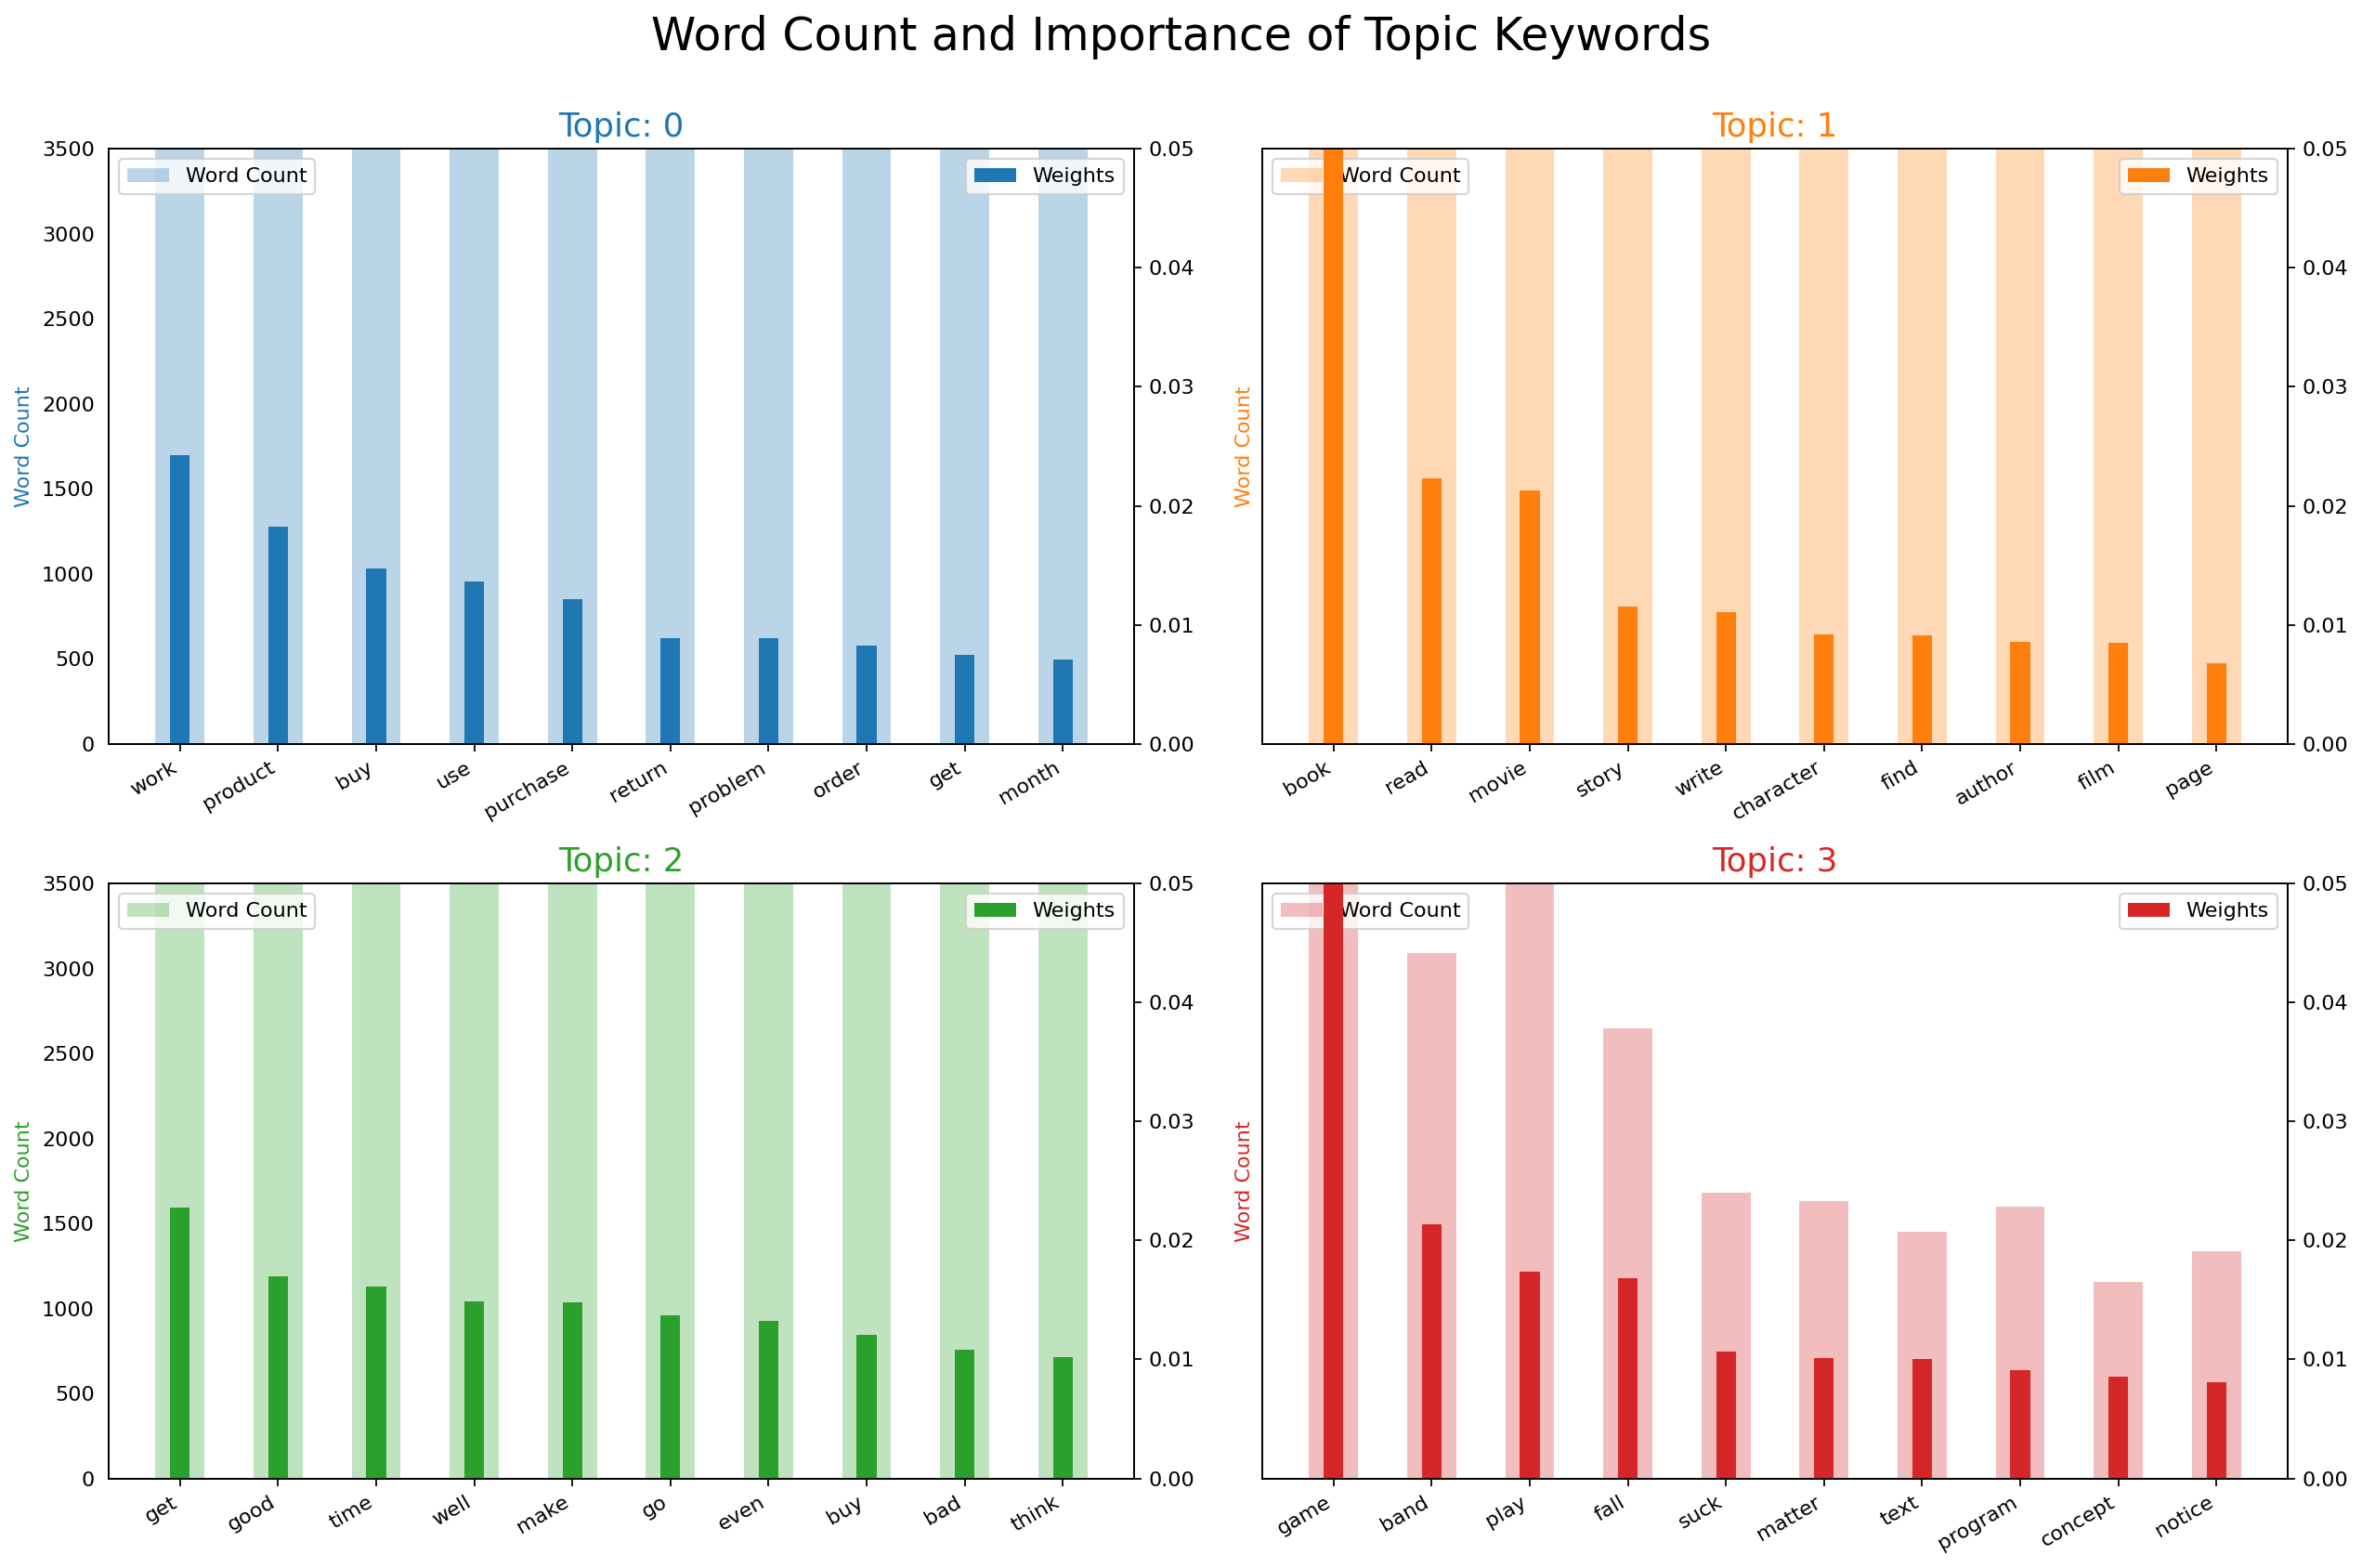

In [109]:
# Obtain topics from the lda_model
topics = lda_model.show_topics(formatted=False)

# Flatten all words into a flat list
data_flat = [w for w_list in texts for w in w_list]

# Count word frequencies
counter = Counter(data_flat)

# Create a DataFrame with words, topics, importance, and word counts
out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i, weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot word counts and weights of topic keywords
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

for i, ax in enumerate(axes.flatten()):
    df_topic = df.loc[df.topic_id == i, :]
    
    # Histogram of word counts
    ax.bar(x='word', height="word_count", data=df_topic, color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    
    # Histogram of word importance
    ax_twin.bar(x='word', height="importance", data=df_topic, color=cols[i], width=0.2, label='Weights')
    
    # Set axis labels
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.050)
    ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    
    # Set x-axis ticks and labels
    ax.set_xticks(range(len(df_topic['word'])))
    ax.set_xticklabels(df_topic['word'], rotation=30, horizontalalignment='right')
    
    ax.tick_params(axis='y', left=False)
    ax.legend(loc='upper left')
    ax_twin.legend(loc='upper right')

# Figure layout
fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

### Sentence Chart Colored by Topic

Now we use a method called `sentence_chart` to visualize the distribution of topics within each document. In this method, each word in the document is representative of one of the 4 topics identified by our model. We define the color of each word in the document based on the topic ID it is attributed to. Additionally, the enclosing rectangle surrounding each document is colored according to the topic assigned to that document. This visualization allows us to easily discern the dominant topics within each document and observe how topics are distributed across the corpus.

In [120]:
def sentences_chart(lda_model=lda_model, corpus=corpus, start=0, end=11):
    '''
    This function generates a visualization to illustrate the topics of each sentence in a series of documents using colored rectangles.

    Parameters:
    - lda_model: The trained LDA model.
    - corpus: The corpus of documents.
    - start: The starting index of the documents to visualize.
    - end: The ending index of the documents to visualize.

    The function ultimately creates a visualization that shows the topics of sentences across multiple documents.
    '''
    # Extract a subset of the corpus
    corp = corpus[start:end]
    # Generate a list of colors for the rectangles
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    # Create a figure and a set of subplots
    fig, axes = plt.subplots(end - start, 1, figsize=(20, (end - start) * 0.95), dpi=160)
    axes[0].axis('off')
    # Iterate through each subplot
    for i, ax in enumerate(axes):
        if i > 0:
            # Extract the current document from the corpus
            corp_cur = corp[i - 1]
            # Get the dominant topics, word ids, and phi values for each word in the document
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            # Extract the word and its dominant topic for each word in the document
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]
            # Add the document label to the subplot
            ax.text(0.01, 0.5, "Doc " + str(i - 1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw a rectangle to represent the dominant topic of the document
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1,
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            # Iterate through each word in the document
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:  # Display only the first 14 words
                    # Display the word horizontally within the rectangle, with color indicating the topic
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # Move the word position for the next iteration
                    ax.axis('off')
            # Add '...' at the end if there are more words in the document
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)

    # Adjust the layout of the subplots
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end - 2), fontsize=22, y=0.95,
                 fontweight=700)
    plt.tight_layout()
    plt.show()

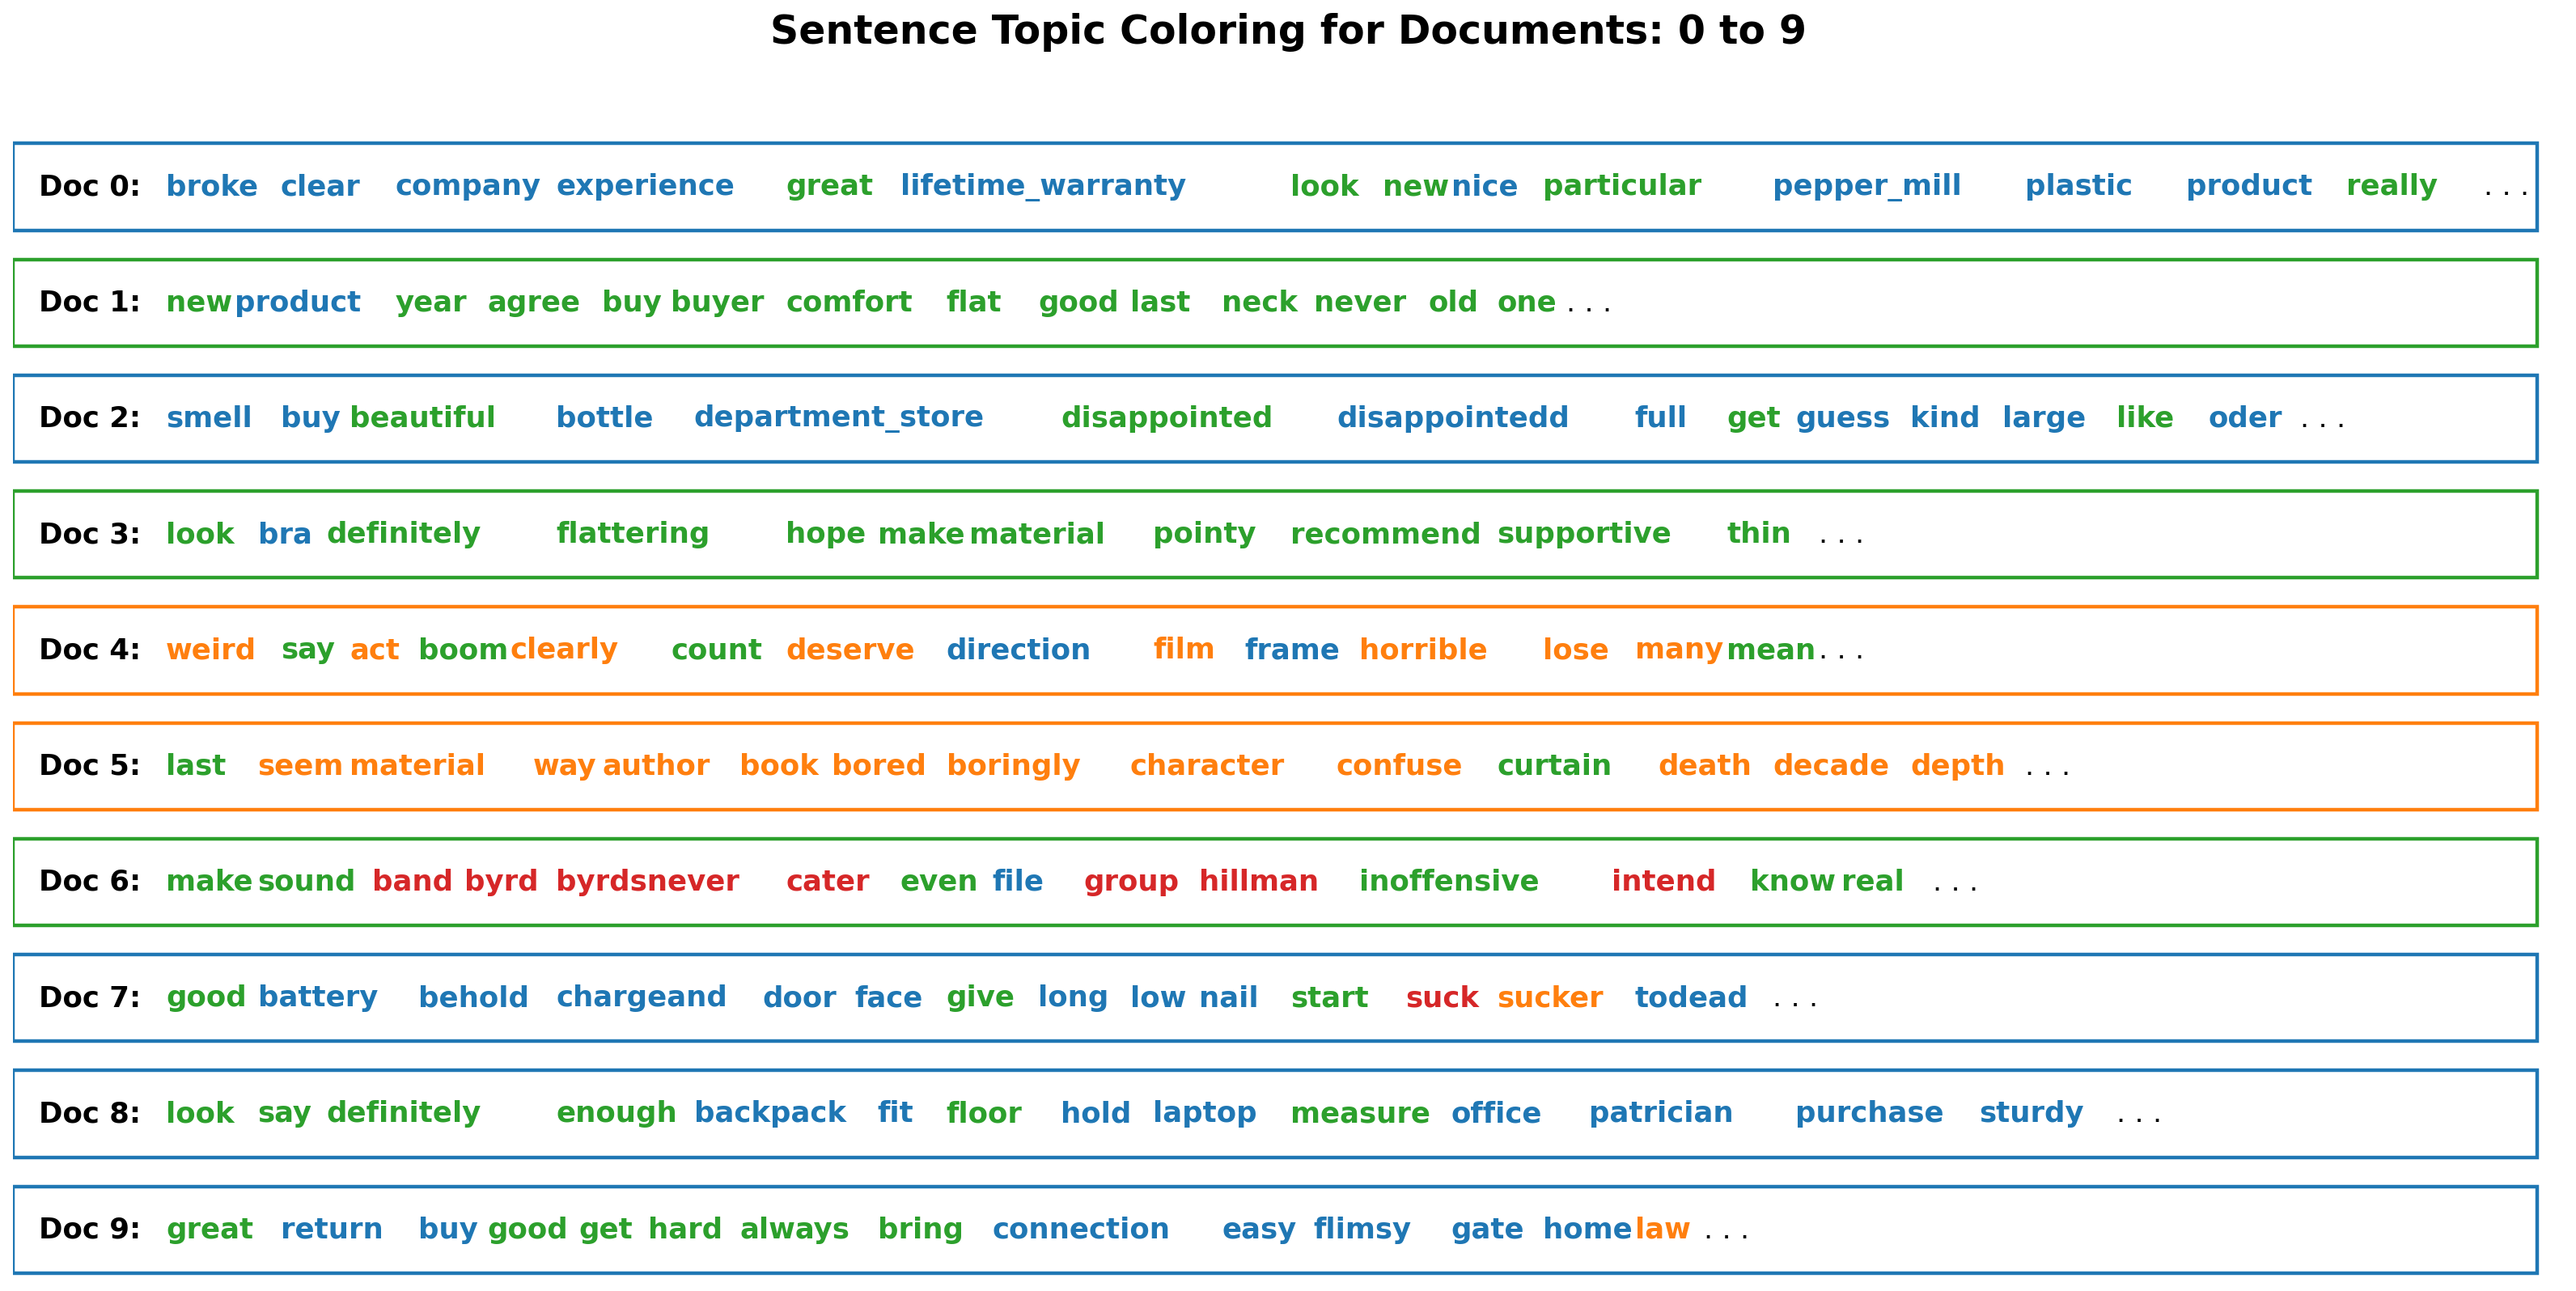

In [121]:
sentences_chart()

In [ ]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

In [ ]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              width=900, height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis